# 1 - Setup

Here's where we install, setup and import the fastbook libs

In [28]:
!pip install -Uqq fastbook
!pip install emoji --upgrade
import fastbook
from fastbook import *
import getpass
import emoji

Requirement already up-to-date: emoji in /opt/conda/envs/fastai/lib/python3.8/site-packages (1.2.0)


# 2 - Get some data 😺
We'll use bing search api to get our dataset.
Each category of images will get it's own subfolder.
This will be important when loading the dataset with the Dataloaders

In [29]:
# Nice way to prompt for API key so we don't have to store it
key = getpass.getpass()

········


In [30]:
tiger_types = 'bengal', 'white', 'teddy'
path = Path('tigers')

In [31]:
path.exists()
# don't forget parenthesis after method calls...

True

In [32]:
if not path.exists():
    path.mkdir()
    for o in tiger_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} tiger')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [33]:
# Clean the datasets up by getting rid of dead links
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

# 3 - Load the data 🚛
We now need to load our data into a DataLoaders so they can be passed into a learner

In [34]:
# Check the docs
??DataBlock

In [35]:
??Resize

In [36]:
# Getting a Dataloaders from a dataset is a 2-step process. 
# First we initialise the Datablock to tell it what to expect the dataset we're about to give it.
tigers = DataBlock(
    
    # This specifies the types of input (images) and output/predictions (categories) we're working with
    # INput is called the INdependent variable
    # Output is called the Dependent variable
    blocks=(ImageBlock, CategoryBlock),
    
    # This tells the datablock how to read the raw data. 
    # Here we'll using get_image_files() as above
    get_items=get_image_files,
    
    # We'll split the dataset into 2 sets: training and validation
    # The learner will train itself on the training set and validate itself using the validation set.
    # The validation set will take 20% of the master set.
    # The seed is set at 42 so re-running against the same set will produce the same training/validation set for consistency
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    
    # get_y tells it how to label or categorise each item in the dataset.
    # parent_label is a built-in function that returns the name of the parent dir
    # Our tiger dataset is currently divided into subdirs tigers/bengali, tigers/white, tigers/teddy
    # Some datasets follow other conventions like having everything in the one dir but the filename 
    # has a particular format to differentiate categories. You could write a small custom function to parse each name
    # and return the label
    get_y=parent_label,
    
    # We need to resize our images to a uniform size.
    # This is so they can be passed around in a uniformly sized array to the GPU
    item_tfms=Resize(128))

In [37]:
# Now that we have our DataBlock template ready to go, we can give it our raw data
dataloaders = tigers.dataloaders(path)

In [38]:
??dataloaders.valid.show_batch

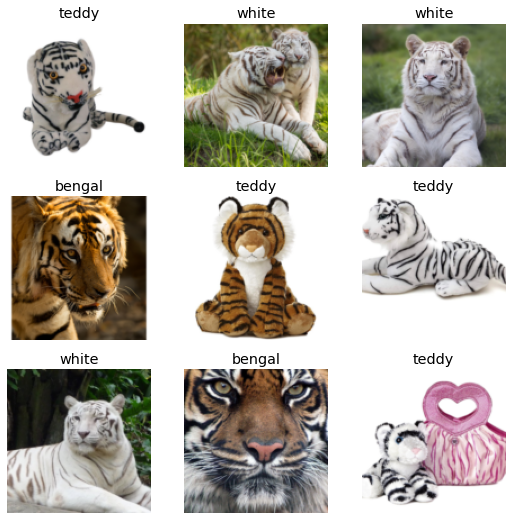

In [39]:
dataloaders.valid.show_batch()

In [40]:
??aug_transforms

In [41]:
# We can augment the data by telling the DataBlock to do some random resizing and cropping on it's training set
# tigers.new is a handy way to update an existing DataBlock rather than starting from scratch
# Just override the params you want updated
tigers = tigers.new(
    # Randomly crop to various points of the image to artificially introduce more variety to the training set.
    # This will make it a bit more robust and (hopefully) able to recognise a wider variety of images
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    # The aug_transforms will create skewed images in the training set for the same reason, more variety
    batch_tfms=aug_transforms())

In [42]:
dataloaders = tigers.dataloaders(path)

# 4 - Training time 🧠
Now we've got the data ready to provide to a learner 

Note how the learning in the cell below is only two lines!

Then compare that how much more work goes into gathering, labelling and preparing of the data. 
Just like any other program: rubbish in, rubbish out 

We initialise the learner with the following information:

1 - our dataloaders full of labelled tiger images split into training and validation sets.

2 - 'resnet18' tells the learner to use the resnet18 pretrained model as a base. This model is an 18-layer neural net which 
     provides a foundation that already knows how to recognise a variety of shapes, gradients, edges and colours

3 - We tell the learner to use error_rate as a metric for determining how well it is doing as it adjusts the weights to fit the training data. Under the hood it's using Stochastic Gradient Descent to find an accurate model.

In [43]:
learner = cnn_learner(dataloaders, resnet18, metrics=error_rate)

# 'fine_tune' adds a random layer to the head of the pre-trained cnn (resnet18) and asks it to go through 20 epochs (rounds) of training
# There is a 'fit' method too but that would start training the whole CNN from scratch which would lose the benefit transfer learning 
# that's already been done with resnet18
learner.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.517691,0.579763,0.183908,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.549974,0.492044,0.137931,00:06
1,0.452628,0.454403,0.126437,00:07
2,0.433029,0.438492,0.114943,00:06
3,0.384847,0.454790,0.103448,00:08
4,0.349378,0.500777,0.114943,00:07
5,0.317676,0.525726,0.114943,00:07
6,0.282301,0.525771,0.126437,00:07
7,0.253006,0.563967,0.126437,00:07
8,0.228877,0.648343,0.114943,00:06
9,0.210335,0.699848,0.103448,00:07


So after 20 epochs the learner this time seemed to settle on an error rate of 0.137931.
This may change with different runs but seems like a fairly decent error rate to me.
I'm curious why it doesn't return to the 0.103 configurations from the earlier epochs. I'll keep an eye out for the answer later on in the course.

One of the things I like about the Fast.ai course is that gets you started building useful things immediately before digging deeper into the how and why of what's going on. Top down learning is definitely my favourite way to tackle new topics: instant gratification followed by gradual deepening mastery.

This philosophy is reflected in the library itself. It provides lots of helper functions and sensible defaults to get started then you can tweak and modify as needed once you know how.

In [44]:
# Check out the documentation for cnn_learner
doc(cnn_learner)

Let's take a look at how the learner did in the end.

We can print out a confusion matrix to indicate which areas it had the most trouble with.

You can see below it mostly had trouble with mistakenly categorising white tigers as bengal tigers. 
Importantly for our personal safety, it was mostly accurate at recognising teddy tigers which are notorious for not mauling people to death 🙀

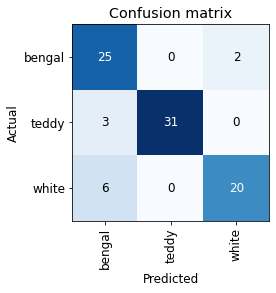

In [45]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

Helpfully we can also print out what the error cases were and we can imediately see a few issues with our labelling.
The first image is clearly a white tiger, the second is definitely not a teddy etc.
This is throwing our model off when we train it and underlines the importance of rubbish in, rubbish out.

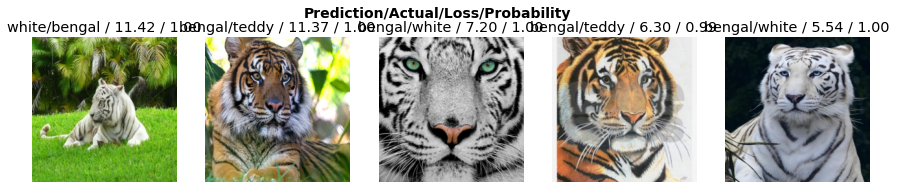

In [46]:
interp.plot_top_losses(5, nrows=1)

Next week I'll take a look at cleaning up the data, retraining and using the results to implement an application to some predictions/inferences on new data.